In [1]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

import auxiliary_functions

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net_rw = ContTempNetwork.load('/home/b/skoove/Desktop/entropy/paper_data/socio_pat_primary_school/primaryschoolnet',
                              attributes_list=['node_to_label_dict',
                      'events_table',
                      'times',
                      'time_grid',
                      'num_nodes',
                      '_overlapping_events_merged',
                      'start_date',
                      'node_label_array',
                      'male_array',
                      'female_array',
                      'node_first_start_array',
                      'node_last_end_array',
                      'node_class_array',
                      'datetimes'])

In [3]:
net_times_hours = net_rw.times / 3600
selected_lamdas = np.logspace(-5,0,10)
windows = [6, 30, 90, 180]

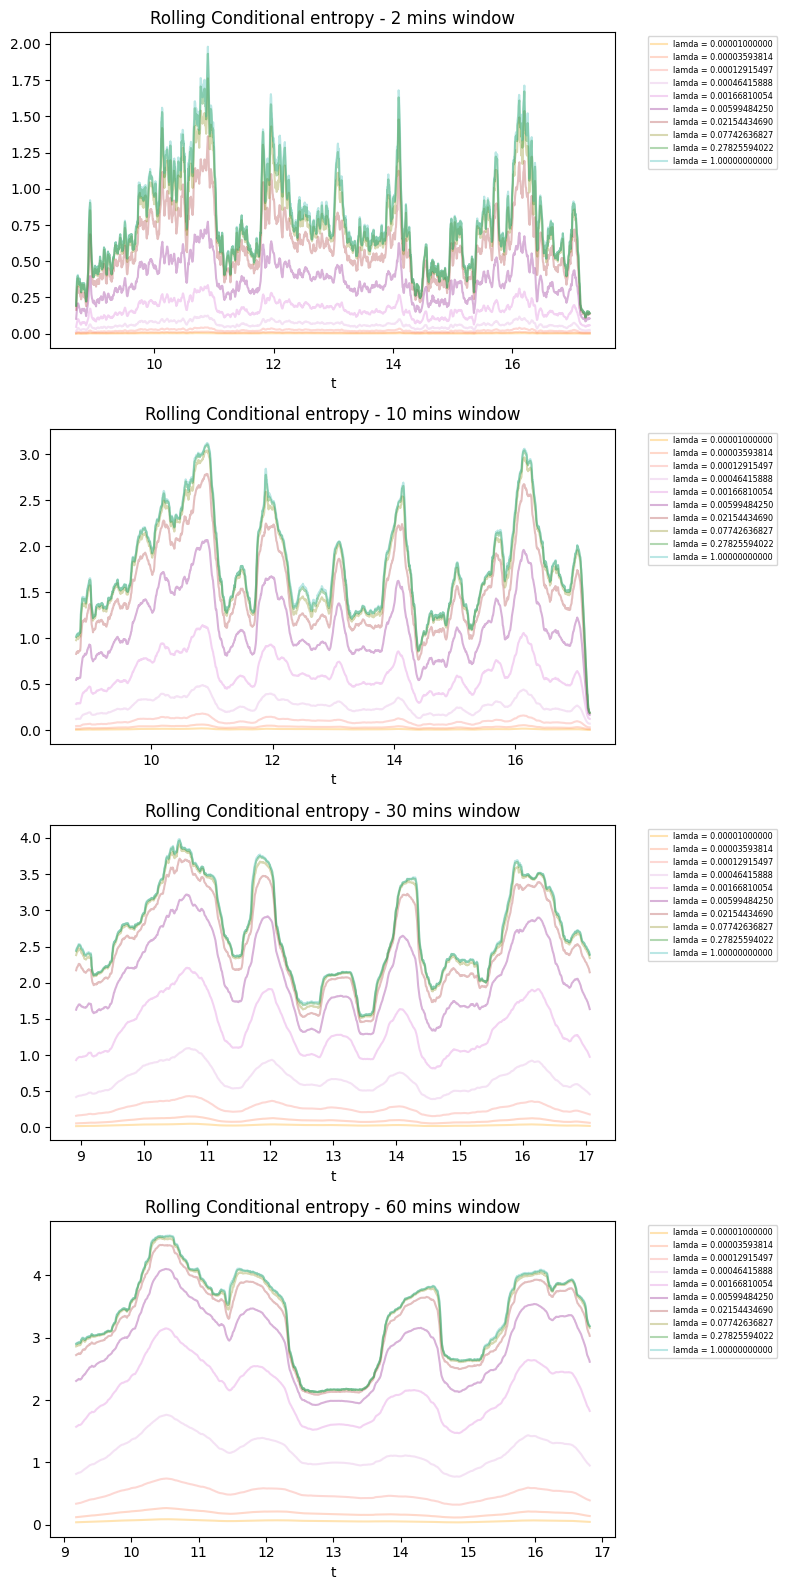

In [4]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
fig, ax = plt.subplots(4,1, figsize = (8, 16))
for j, window in enumerate(windows):
    window_S_selected = []
    for i, lamda in enumerate(selected_lamdas):
        with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
            S_rate = pickle.load(f)
            window_S_selected.append(S_rate['window_S'][f'{lamda:.11f}'])

    
    for i, lamda in enumerate(selected_lamdas):
        S = window_S_selected[i]
        ax[j].plot(net_times_hours[(window // 2)+1 :1556- (window // 2)], S[1:1556-window], color = list_colors[i], alpha = 0.30, label='lamda = ' + f'{lamda:.11f}')
        ax[j].set_xlabel('t')

    ax[j].legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
    ax[j].set_title(f'Rolling Conditional entropy - {window // 3} mins window')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/primary_school_windows.eps', format='eps', dpi=300)
plt.show()

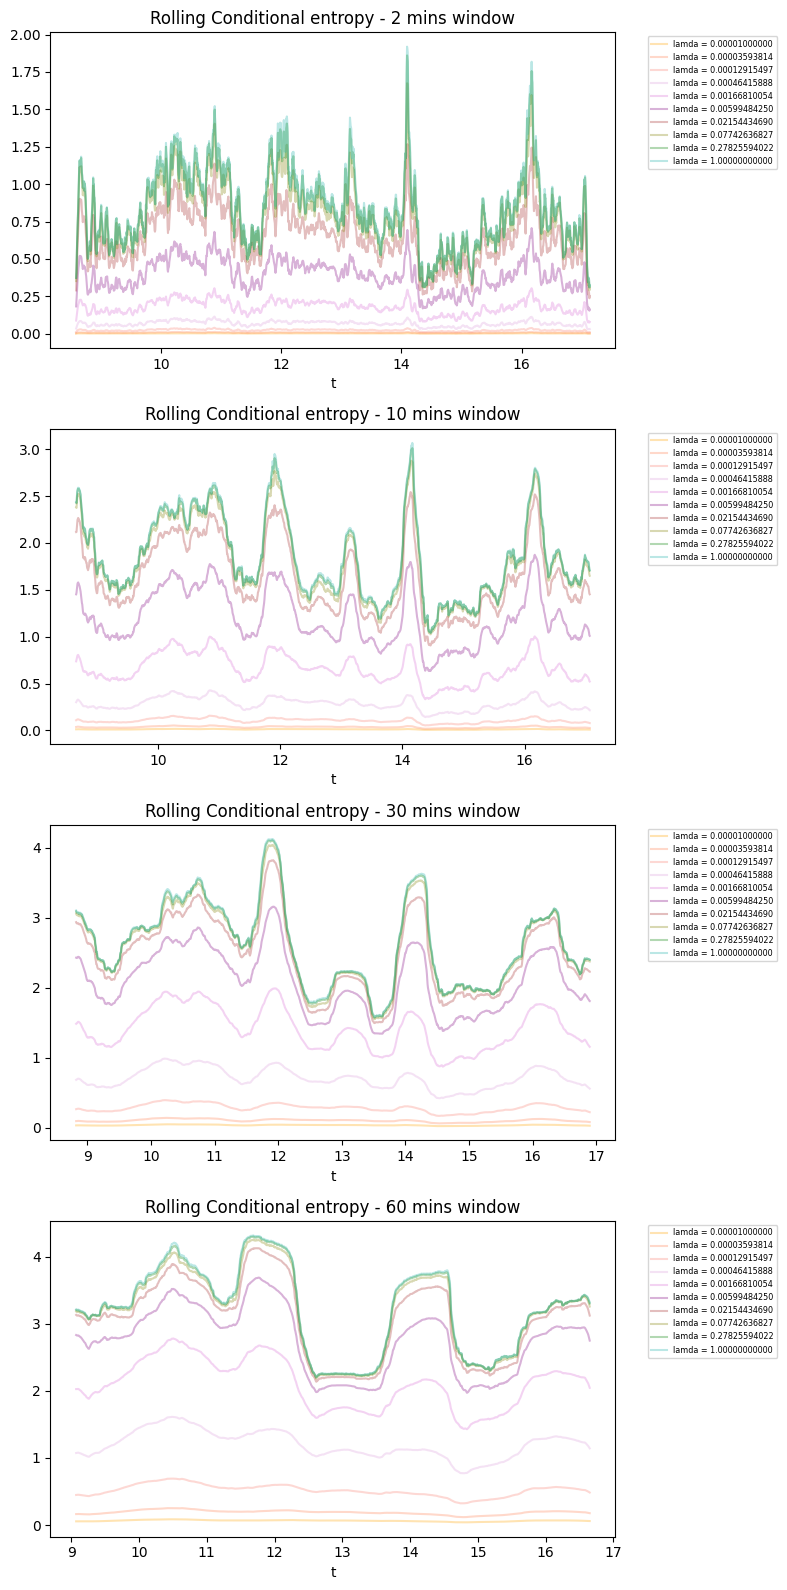

In [5]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
fig, ax = plt.subplots(4,1, figsize = (8, 16))
for j, window in enumerate(windows):
    window_S_selected = []
    for i, lamda in enumerate(selected_lamdas):
        with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw_day2/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
            S_rate = pickle.load(f)
            window_S_selected.append(S_rate['window_S'][f'{lamda:.11f}'])

    
    for i, lamda in enumerate(selected_lamdas):
        S = window_S_selected[i]
        ax[j].plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, S[1:1546-window], color = list_colors[i], alpha = 0.30, label='lamda = ' + f'{lamda:.11f}')
        ax[j].set_xlabel('t')

    ax[j].legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
    ax[j].set_title(f'Rolling Conditional entropy - {window // 3} mins window')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/primary_school_windows.eps', format='eps', dpi=300)
plt.show()

# Comparison Between the two

In [6]:
print('Beginning of Day 1: ' + str(net_times_hours[(window // 2)+1]))
print('End of Day 1: ' + str(net_times_hours[1556- (window // 2)]))
print('Beginning of Day 2: ' + str( net_times_hours[1556 + (window // 2)]-24))
print('End of Day 2: ' + str(net_times_hours[-(window // 2)]-24))

Beginning of Day 1: 9.177777777777777
End of Day 1: 16.816666666666666
Beginning of Day 2: 9.06666666666667
End of Day 2: 16.65555555555556


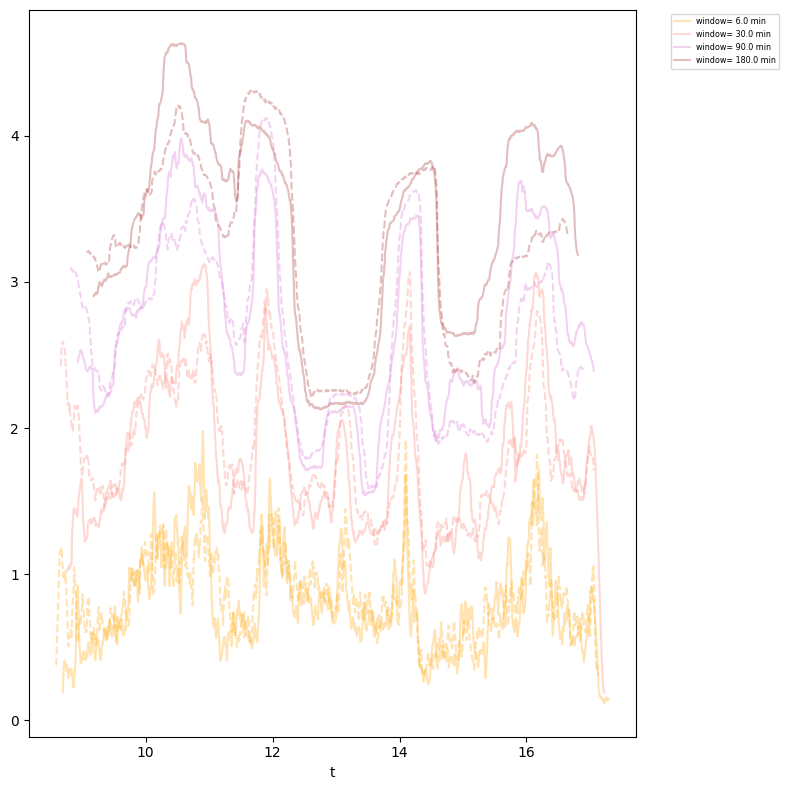

In [7]:
#Plot 5
list_colors = ['orange', 'salmon', 'orchid', 'brown']
lamda = selected_lamdas[-1]

fig, ax = plt.subplots(1,1, figsize = (8, 8))
for j, window in enumerate(windows):

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day1 = (S_rate['window_S'][f'{lamda:.11f}'])

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw_day2/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day2  = (S_rate['window_S'][f'{lamda:.11f}'])

    S = window_S_selected_day1
    ax.plot(net_times_hours[(window // 2)+1 :1556- (window // 2)], S[1:1556-window], color = list_colors[j], alpha = 0.30, label='window= ' + f'{window:.1f} min')
    
    S = window_S_selected_day2
    ax.plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, S[1:1546-window], color = list_colors[j], alpha = 0.30, linestyle='dashed')
    
    ax.set_xlabel('t')
    ax.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
    #ax.set_title(f'Rolling Conditional entropy - {window // 3} mins window')
plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/primary_school_windows.eps', format='eps', dpi=300)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


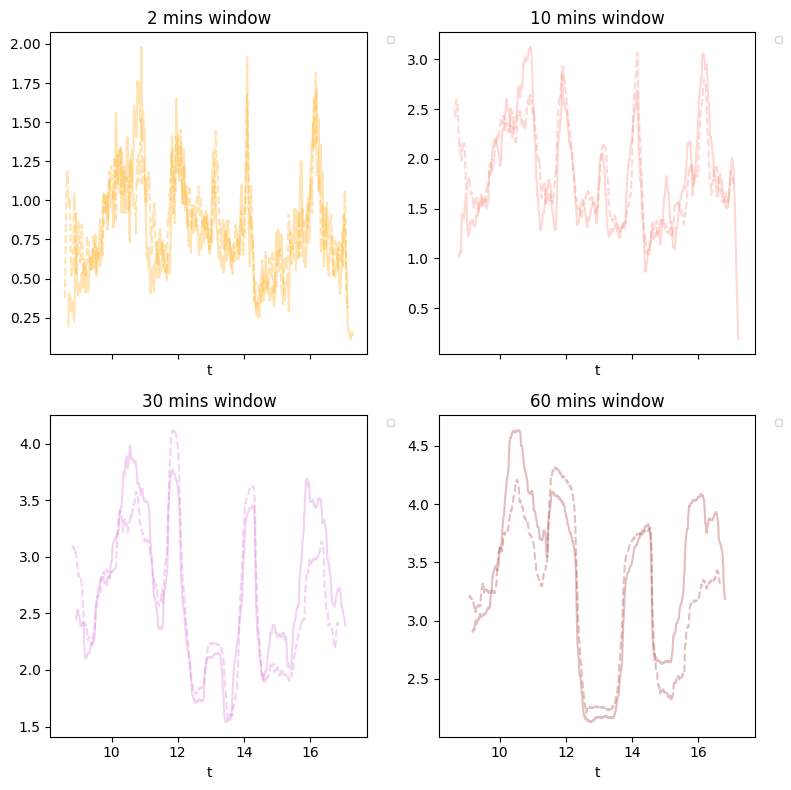

In [8]:
#Plot 5
list_colors = ['orange', 'salmon', 'orchid', 'brown']
lamda = selected_lamdas[-1]

indices_plot = [[0,0], [0,1], [1,0], [1,1]]

fig,ax = plt.subplots(2,2, figsize = (8, 8), sharex=True)

for j, window in enumerate(windows):

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day1 = (S_rate['window_S'][f'{lamda:.11f}'])

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw_day2/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day2  = (S_rate['window_S'][f'{lamda:.11f}'])

    S = window_S_selected_day1
    ax[indices_plot[j][0], indices_plot[j][1]].plot(net_times_hours[(window // 2)+1 :1556- (window // 2)], S[1:1556-window], color = list_colors[j], alpha = 0.30)
    
    S = window_S_selected_day2
    ax[indices_plot[j][0], indices_plot[j][1]].plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, S[1:1546-window], color = list_colors[j], alpha = 0.30, linestyle='dashed')
    
    ax[indices_plot[j][0], indices_plot[j][1]].set_xlabel('t')
    ax[indices_plot[j][0], indices_plot[j][1]].legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
    ax[indices_plot[j][0], indices_plot   [j][1]].set_title(f'{window // 3} mins window')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/primary_school_window_day1day2.eps', format='eps', dpi=300)
plt.show()

# Fourier

In [9]:
window = 90
lamda = selected_lamdas[-1]
with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw_day2/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day2  = (S_rate['window_S'][f'{lamda:.11f}'])
S = window_S_selected_day2

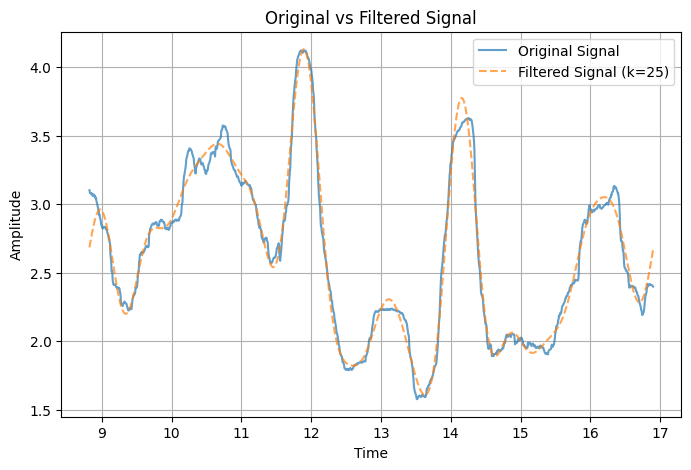

In [10]:
# Example usage:
dt = net_times_hours[1] - net_times_hours[0]
k = 25  # Number of dominant frequencies to keep
reconstructed_signal, freqs, fft_vals_filtered = auxiliary_functions.filter_signal(S[1:], dt, k)

# Generate time axis
#dt = (net_times_hours[- (window // 2)] - net_times_hours[(window // 2)+1] ) / len(net_times_hours[(window // 2)+1 : - (window // 2)])
#time = np.arange(len(S[1:])) * dt

# Plot original and reconstructed signals
plt.figure(figsize=(8, 5))
plt.plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, S[1:], label="Original Signal", alpha=0.7)
plt.plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, reconstructed_signal, '--', label=f"Filtered Signal (k={k})", alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Filtered Signal')
plt.legend()
plt.grid()
plt.show()

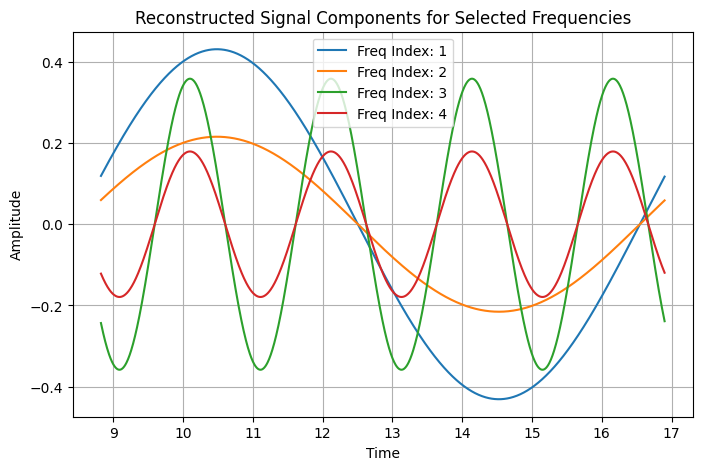

In [11]:
# Example usage:
indices_to_keep = range(1,5)  # Select specific frequency indices based on magnitude
reconstructed_signals, freqs = auxiliary_functions.extract_frequencies(S[1:], dt, indices_to_keep)

# Generate time axis
time = np.arange(len(S[1:])) * dt

# Plot each selected frequency component
plt.figure(figsize=(8, 5))

i=0
for idx, signal in reconstructed_signals.items():
    plt.plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, signal, label=f"Freq Index: {indices_to_keep[i]}")
    i+=1

# Plot settings
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Signal Components for Selected Frequencies')
plt.legend()
plt.grid()
plt.show()

# For Talk

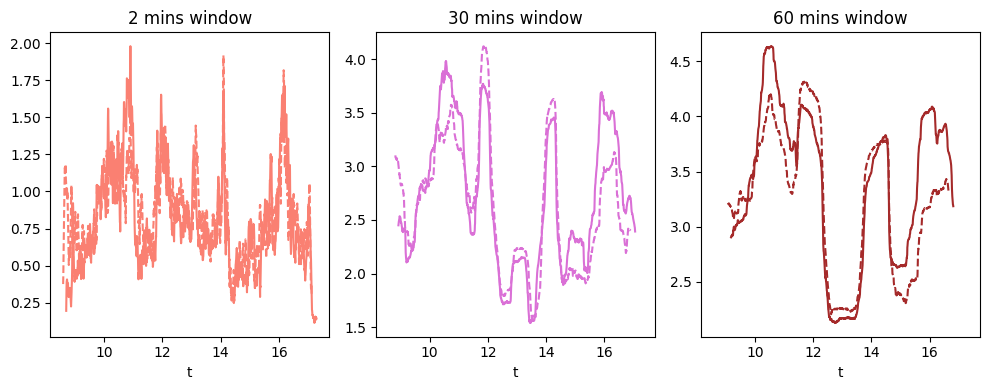

In [20]:
#Plot 5
windows = [6, 90, 180]
list_colors = ['salmon', 'orchid', 'brown']
lamda = selected_lamdas[-1]

indices_plot = [0, 1, 2]

fig,ax = plt.subplots(1,3, figsize = (10, 4), sharex=True)

for j, window in enumerate(windows):

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day1 = (S_rate['window_S'][f'{lamda:.11f}'])

    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw_day2/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate= pickle.load(f)
        window_S_selected_day2  = (S_rate['window_S'][f'{lamda:.11f}'])

    S = window_S_selected_day1
    ax[indices_plot[j]].plot(net_times_hours[(window // 2)+1 :1556- (window // 2)], S[1:1556-window], color = list_colors[j], alpha = 1)
    
    S = window_S_selected_day2
    ax[indices_plot[j]].plot(net_times_hours[1556 + (window // 2)+1 : -(window // 2)]-24, S[1:1546-window], color = list_colors[j], alpha = 1, linestyle='dashed')
    
    ax[indices_plot[j]].set_xlabel('t')
    ax[indices_plot[j]].set_title(f'{window // 3} mins window')

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/primary_school/primary_school_window_day1day2_slides.png', format='png', dpi=300)
plt.show()